Before we start training process you should change runtime type.
1. Click to Runtime --> Change runtime type.
2. Choose "T4 GPU" and save it.

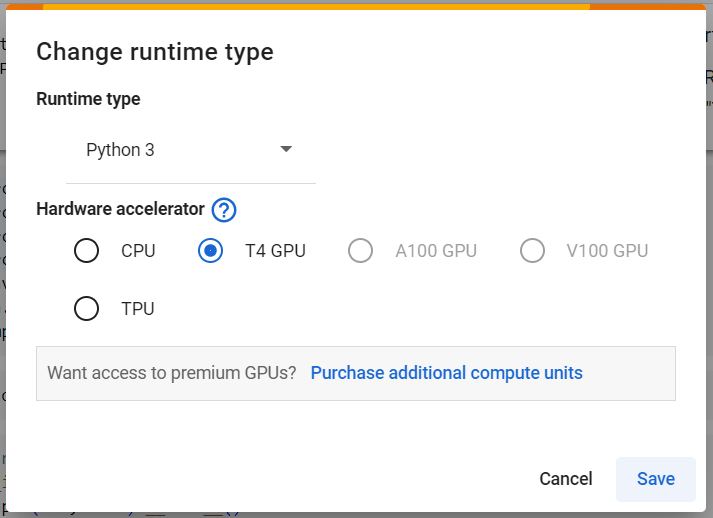

3. Upload test images to colab

Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt


Check if a GPU is available



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define a transform to normalize the data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


Set the batch size to match your device's available memory.

In [4]:
batch_size = 64


Load CIFAR-10 dataset



In [5]:

trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net().to(device)

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [9]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            test_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))


In [10]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
torch.save(model.state_dict(), 'cifar_cnn_model.pth')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.329404
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.137969
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.884752
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.763020
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.689586
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.748043
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.598352
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.523149

Test set: Average loss: 0.0224, Accuracy: 4737/10000 (47.37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.763156
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.418432
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.441999
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.442467
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.456922
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.363068
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.393074
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.301087

Test set: Average loss: 0.0185, Accuracy: 5779/10000 (57.79%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.054847
Train Epoch: 3 [6400/50000 (13%)]	Loss:

In [11]:
# Create an instance of 'Net' and move it to the same device as the original model
loaded_net = Net().to(device)

# Load the saved state dictionary
checkpoint = torch.load('cifar_cnn_model.pth')

# Load the state dictionary into 'Net'
loaded_net.load_state_dict(checkpoint)

<All keys matched successfully>

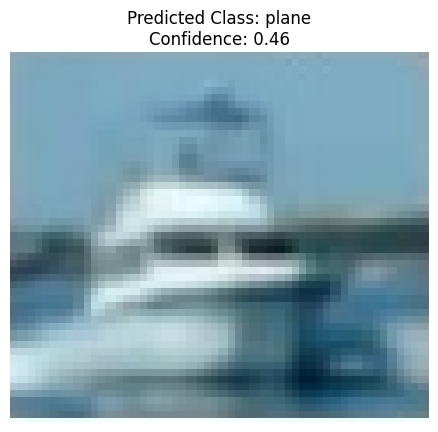

In [12]:
image = cv2.imread("cifar_img1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

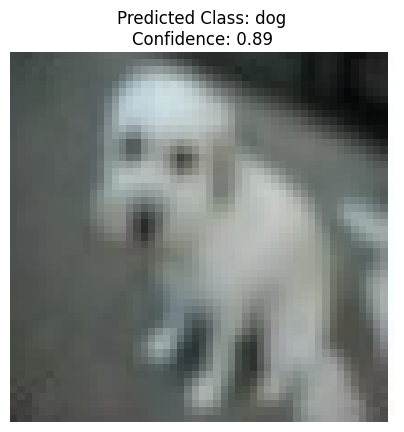

In [13]:
image = cv2.imread("cifar_img2.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()

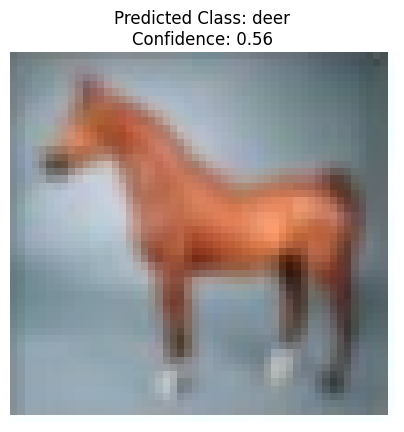

In [14]:
image = cv2.imread("cifar_img3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize the image to match the model's input size
    transforms.ToTensor(),
])

input_image = transform(image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)# Move the input to the GPU if available

with torch.no_grad():
    outputs = loaded_net(input_image)  # Unsqueeze to add batch dimension
_, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

# Get the prediction confidence
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

# # Show the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()